In [13]:
# Importing libraries
import cv2
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import random
import requests
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix 
import time
from timeit import default_timer as timer
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [15]:
# Split data into train, validate and test
with open('../data/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('../data/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('../data/test.p', 'rb') as f:
  test_data = pickle.load(f)

# Split into inputs and outputs
x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

In [16]:
# Check lenght of datasets
print(f"Lenght of train: {x_train.shape[0]}")
print(f"Lenght of validation: {x_val.shape[0]}")
print(f"Lenght of test: {x_test.shape[0]}")

Lenght of train: 34799
Lenght of validation: 4410
Lenght of test: 12630


In [17]:
# Check if the number of inputs is the same as the number of outputs
assert(x_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(x_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(x_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"

# Check if shape of data is correct
assert(x_train.shape[1:] == (32, 32, 3)), "The dimension of the images are not 32 x 32 x 3"
assert(x_val.shape[1:] == (32, 32, 3)), "The dimension of the images are not 32 x 32 x 3"
assert(x_test.shape[1:] == (32, 32, 3)), "The dimension of the images are not 32 x 32 x 3"

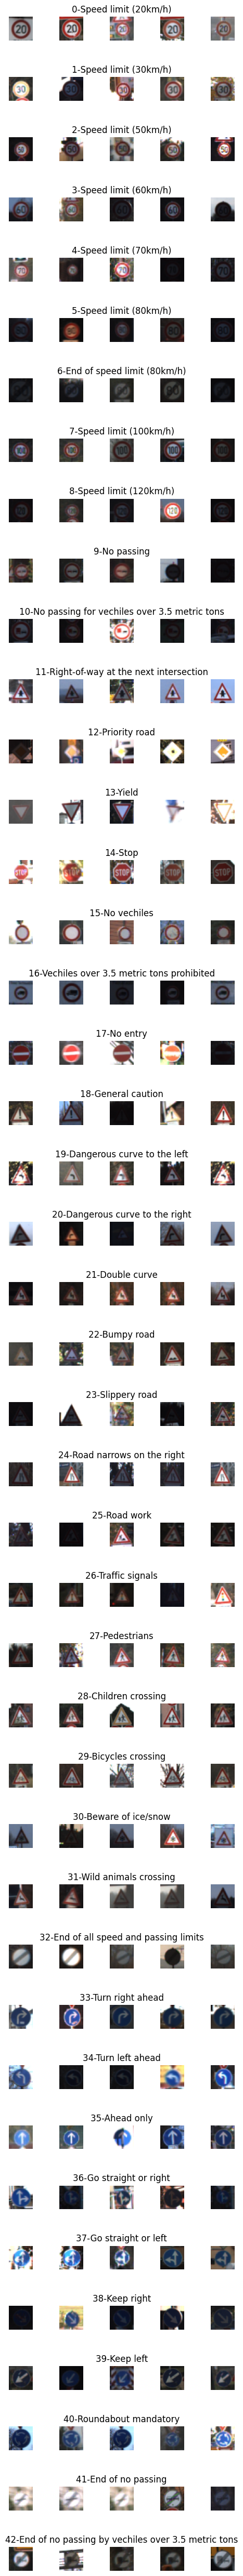

In [18]:
# Load names of traffic sign categories
data = pd.read_csv('../data/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43

# Display 5 random images per each category of traffic signs
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

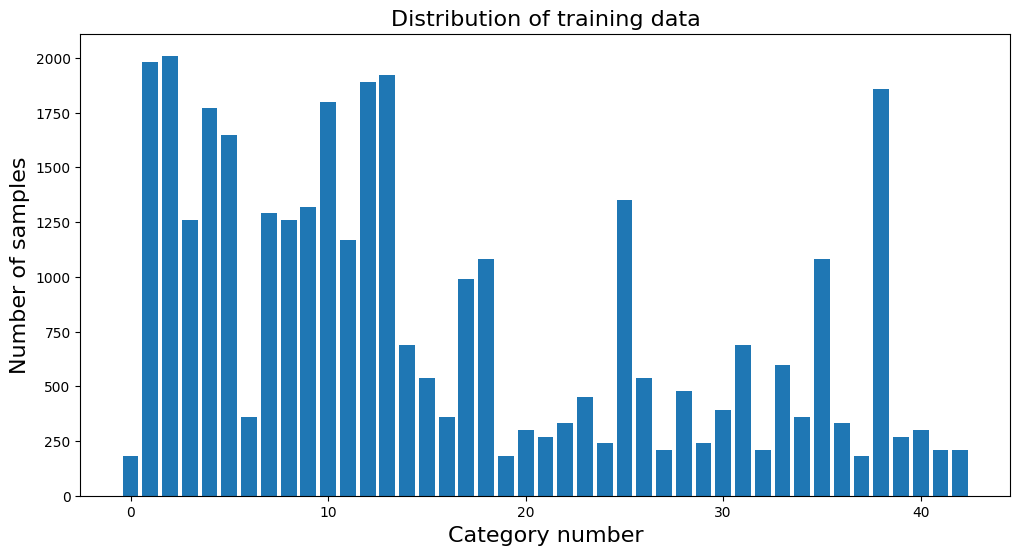

In [19]:
# Plot number of samples per category of traffic signs
plt.figure(figsize=(12, 6))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of training data", fontsize=16)
plt.xlabel("Category number", fontsize=16)
plt.ylabel("Number of samples", fontsize=16)
plt.show()

Image shape: (32, 32, 3)
Category number: 36



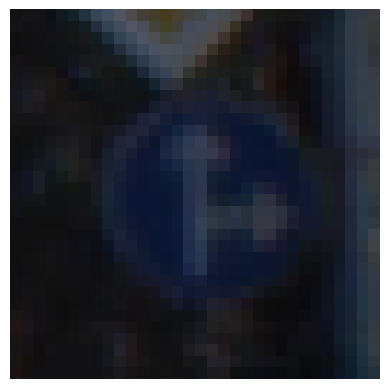

In [20]:
# Display random image from the dataset
plt.imshow(x_train[1000])
plt.axis("off")
print(f"Image shape: {x_train[1000].shape}")
print(f"Category number: {y_train[1000]}\n")

Shape after grayscale: (32, 32)



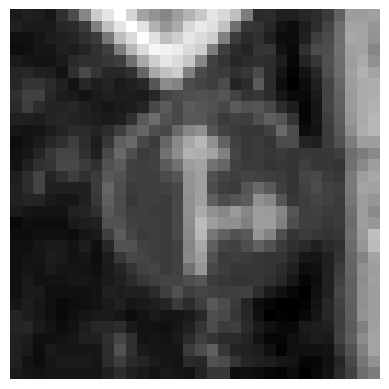

In [21]:
# Convert the randomly selected image to grayscale
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(x_train[1000])
plt.imshow(img, cmap='gray')
plt.axis("off")
print(f"Shape after grayscale: {img.shape}\n")

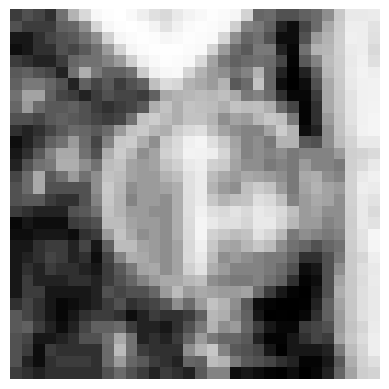

In [22]:
# Perform histogram equalization on the randomly selected image
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

In [23]:
# Perform grayscale conversion, histogram equalization and normalization on the whole dataset
def preporocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

x_train = np.array(list(map( preporocessing, x_train)))
x_val = np.array(list(map( preporocessing, x_val)))
x_test = np.array(list(map( preporocessing, x_test)))

Shape of training dataset: (34799, 32, 32)



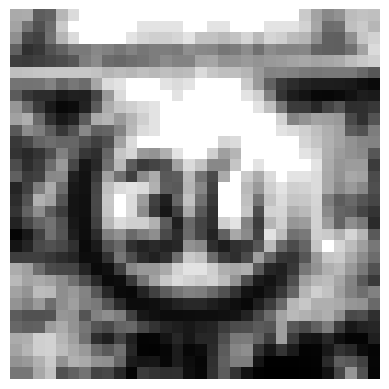

In [24]:
# Random image from the dataset after image processing
plt.imshow(x_train[random.randint(0, len(x_train) - 1)], cmap='gray')
plt.axis("off")
print(f"Shape of training dataset: {x_train.shape}\n")

In [25]:
# Reshape data to have depth of one (grayscale)
x_train = x_train.reshape(34799, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)

In [26]:
# Perform image augmentation on training dataset
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
datagen.fit(x_train)

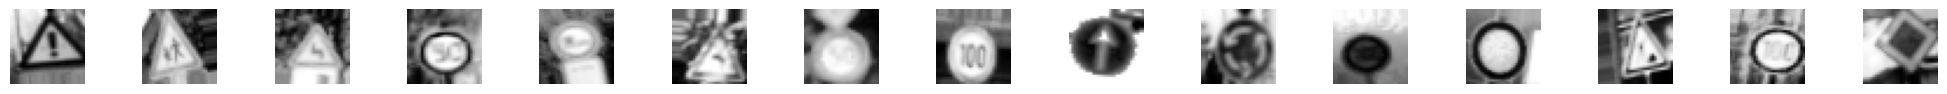

In [27]:
# Split training dataset into smaller chunks 
batches = datagen.flow(x_train, y_train, batch_size=256)
x_batch, y_batch = next(batches)

# Plot sample of images after augmentation
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32, 32), cmap='gray')
  axs[i].axis('off')

In [28]:
# Convert classes to categorical vectors
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [29]:
# Create model - Deep Convolutional Neural Network
def modified_model():
  model = Sequential()
  model.add(Conv2D(32, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(32, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(64, (5, 5), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [30]:
# Model representation
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [31]:
# Training the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=20, validation_data=(x_val, y_val), shuffle = 1)

Epoch 1/20



544/544 [==============================] - 25s 43ms/step - loss: 2.5142 - accuracy: 0.2857 - val_loss: 0.8663 - val_accuracy: 0.6868
Epoch 2/20
544/544 [==============================] - 23s 43ms/step - loss: 0.8426 - accuracy: 0.7340 - val_loss: 0.2653 - val_accuracy: 0.9122
Epoch 3/20
544/544 [==============================] - 23s 41ms/step - loss: 0.4486 - accuracy: 0.8566 - val_loss: 0.1620 - val_accuracy: 0.9454
Epoch 4/20
544/544 [==============================] - 22s 40ms/step - loss: 0.3179 - accuracy: 0.9000 - val_loss: 0.0746 - val_accuracy: 0.9776
Epoch 5/20
544/544 [==============================] - 22s 40ms/step - loss: 0.2450 - accuracy: 0.9247 - val_loss: 0.0634 - val_accuracy: 0.9785
Epoch 6/20
544/544 [==============================] - 22s 41ms/step - loss: 0.2111 - accuracy: 0.9359 - val_loss: 0.0529 - val_accuracy: 0.9850
Epoch 7/20
544/544 [==============================] - 22s 40ms/step - loss: 0.1957 - accuracy: 0.9429 - val_loss: 0.0585 - val_accuracy: 0.9810
Epo

In [34]:
model.save('../CNN_model/cnn_classifier.keras')

best_model = load_model('../CNN_model/cnn_classifier.keras')

In [35]:
# Load the names of traffic signs (in Croatian)
labelNames = open("../data/signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

# Evaluate the best performing model
print("[INFO] evaluating network...")
predictions = best_model.predict(x_val, batch_size=64)
print(classification_report(y_val.argmax(axis=1),	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
69/69 [==============================] - 1s 11ms/step
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      1.00      1.00        30
                              Speed limit (30km/h)       1.00      1.00      1.00       240
                              Speed limit (50km/h)       1.00      0.97      0.99       240
                              Speed limit (60km/h)       0.97      1.00      0.99       150
                              Speed limit (70km/h)       1.00      1.00      1.00       210
                              Speed limit (80km/h)       0.97      0.99      0.98       210
                       End of speed limit (80km/h)       1.00      1.00      1.00        60
                             Speed limit (100km/h)       0.99      0.99      0.99       150
                             Speed limit (120km/h)       1.00      0.98      0.99       

Original shape of y_test: (12630, 43)
Reshaped shape of y_test: (12630,)
395/395 [==============================] - 3s 7ms/step


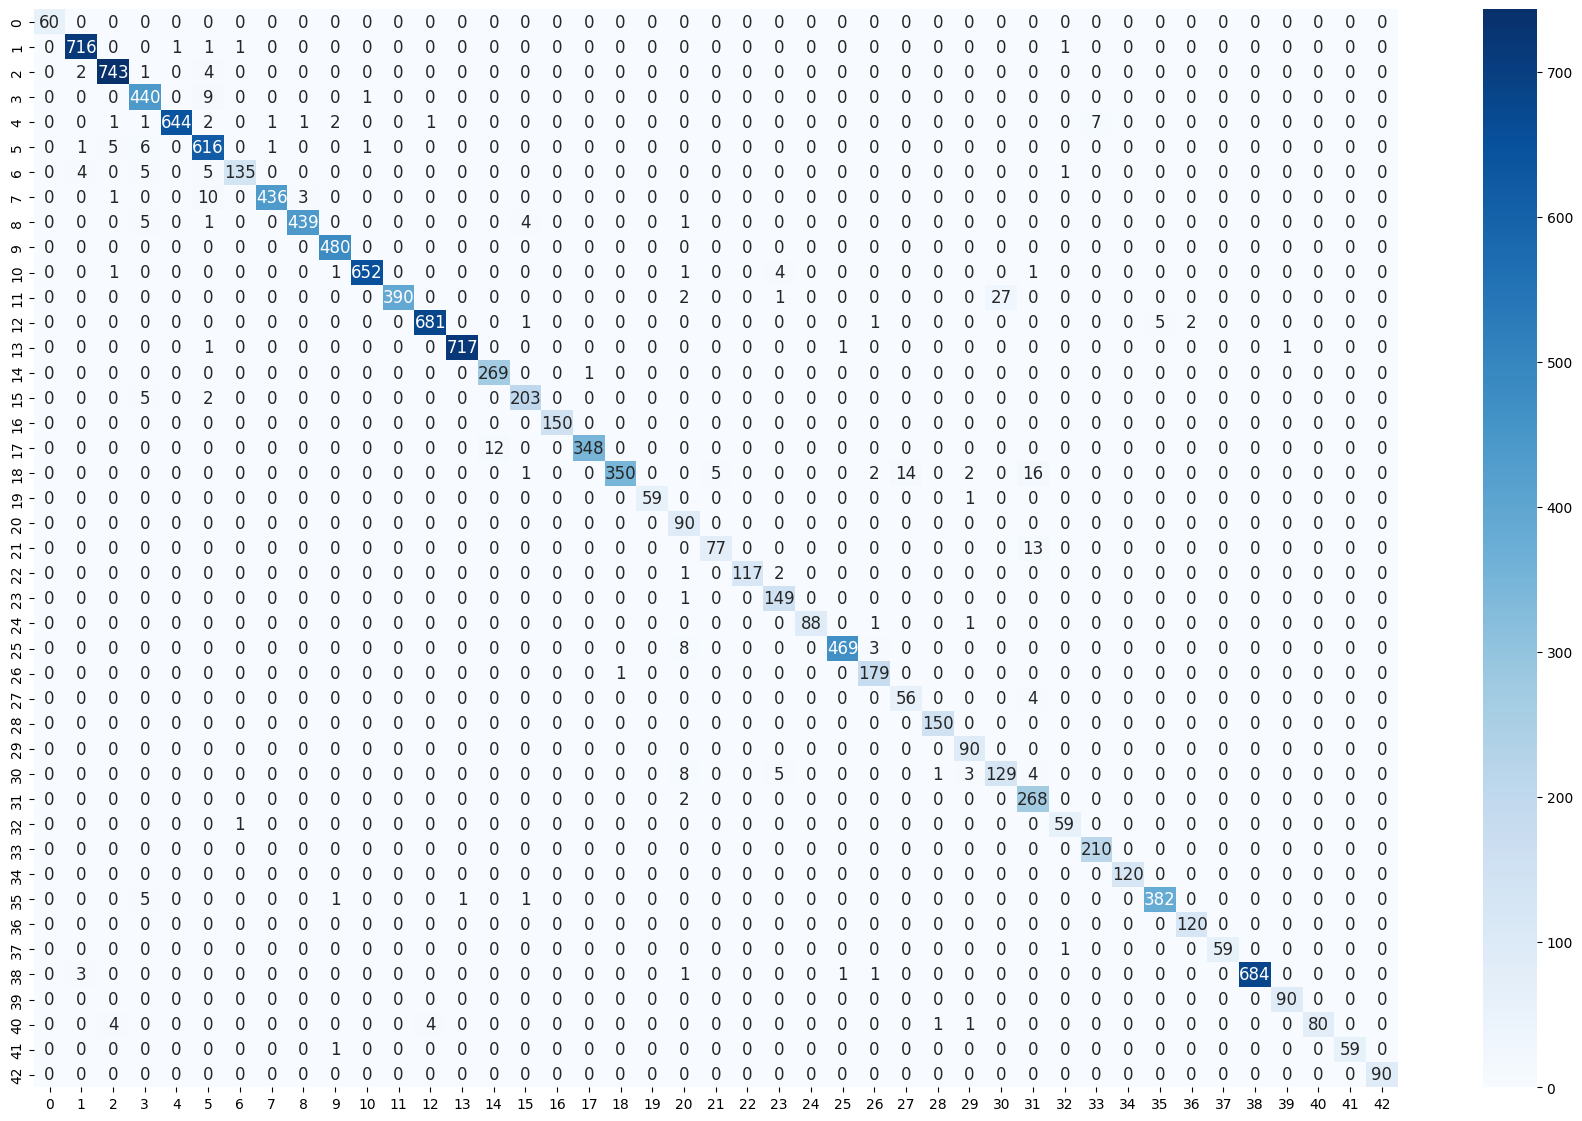

In [36]:
# Check the shape of y_test
print("Original shape of y_test:", y_test.shape)

# If y_test is a 2D array, reshape it to 1D
if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)
    print("Reshaped shape of y_test:", y_test.shape)
    
# Create confusion matrix for the best performing model
y_pred = best_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Ensure y_test is a 1D array
y_test = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix for the best performing model
plt.figure(figsize=(22, 14))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', annot_kws={'size': 12})
plt.show()


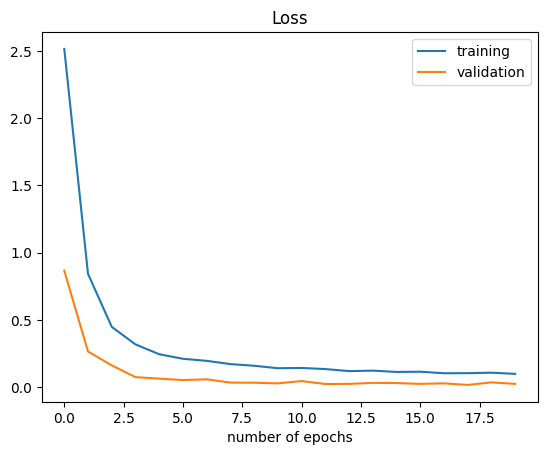

In [37]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('number of epochs')
plt.show()

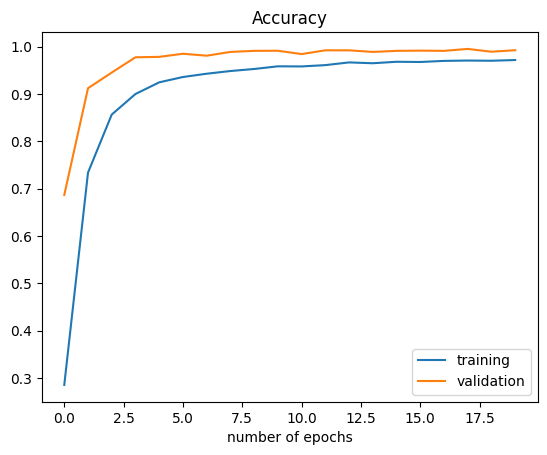

In [38]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('number of epochs')
plt.show()

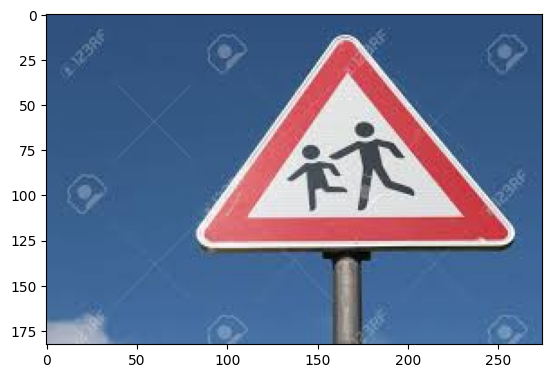

In [39]:
# Examples of traffic signs for testing the model
#url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg' #speed limit 30 [1]
#url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg' #must turn left [34]
#url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg' #slippery road [23]
#url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg' #yield [13]
#url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg' #bicycle crossing [29]
#url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRqrfBCIB2iuquMh_aBYVBOB5U5zBbBEwRWlQ&usqp=CAU' #roadwork [25]
#url = 'https://miro.medium.com/max/734/1*m3L5X3ic_VMwQH1NTdZ1FA.png' #bumpy road [22]
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTfYwEafxFmV3vrRgNcra-PB5xX3qmnFFAIUA&usqp=CAU' #children crossing [28]

# Load an image
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img)
plt.show()

Shape after preprocessing: (32, 32)



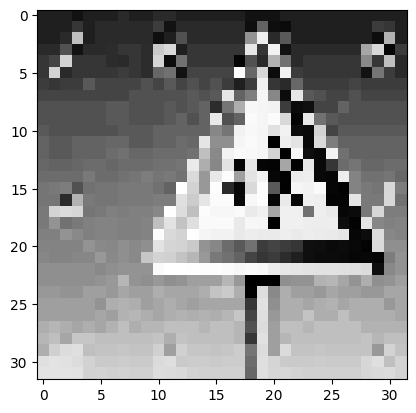

In [40]:
#Preprocess the image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preporocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(f"Shape after preprocessing: {img.shape}\n")

In [41]:
#Reshape the image
img = img.reshape(1, 32, 32, 1)

In [42]:
#Test model on the image
print("Category number of predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 0s 109ms/step
Category number of predicted sign: [28]
